In [1]:
# import modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn import datasets
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# BIO VS COMP

In [2]:
# READ IN DATA

df = pd.read_csv("./dataset.csv")

# drop the questions that were not added until after 2020
all_years = df.drop(["command_line","other_countries","across_languages"], axis=1)

# mask for only 2020
only_y20 = all_years[all_years["year"]=="y20"]

# get column names
only_y20.columns

Index(['year', 'survey', 'type', 'type_survey', 'year_type_survey', 'coding',
       'statistics', 'modeling', 'bioinformatics', 'comp_resources', 'mol_bio',
       'gen_breed', 'plant_devo', 'phylogen', 'team', 'management',
       'interdisc', 'sci_comm', 'sci_writing'],
      dtype='object')

In [3]:
# CREATE LDA MODEL

# define predictor (X) and response (y) variables
X = only_y20[['coding', 'statistics', 'modeling', 'bioinformatics', 'comp_resources',
       'mol_bio', 'gen_breed', 'plant_devo', 'phylogen', 'team', 'management',
       'interdisc', 'sci_comm', 'sci_writing']]
y = only_y20['type']

# scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

# fit the LDA model for only 2020 data
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# use data from all years to project onto the 2020 model
Xdata = all_years[['coding', 'statistics', 'modeling', 'bioinformatics', 'comp_resources',
       'mol_bio', 'gen_breed', 'plant_devo', 'phylogen', 'team', 'management',
       'interdisc', 'sci_comm', 'sci_writing']]

# get lda scores 
lda_scores = lda.transform(Xdata) 


/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


In [4]:
# GET SCALINGS

print(lda.scalings_)
print(lda.transform(np.identity(14)))

[[-0.55895069]
 [ 1.01073045]
 [ 0.89659744]
 [-0.25356726]
 [ 0.65961454]
 [-1.38613226]
 [ 0.06908013]
 [-0.85229792]
 [ 0.80932627]
 [ 0.50116939]
 [-0.42605403]
 [-0.01681558]
 [ 0.21513876]
 [ 0.64276552]]
[[-0.55895069]
 [ 1.01073045]
 [ 0.89659744]
 [-0.25356726]
 [ 0.65961454]
 [-1.38613226]
 [ 0.06908013]
 [-0.85229792]
 [ 0.80932627]
 [ 0.50116939]
 [-0.42605403]
 [-0.01681558]
 [ 0.21513876]
 [ 0.64276552]]


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_77922/3344383018.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.scalings = pd.DataFrame(list(zip(questions, scalings)),


<Axes: xlabel='scaling', ylabel='question'>

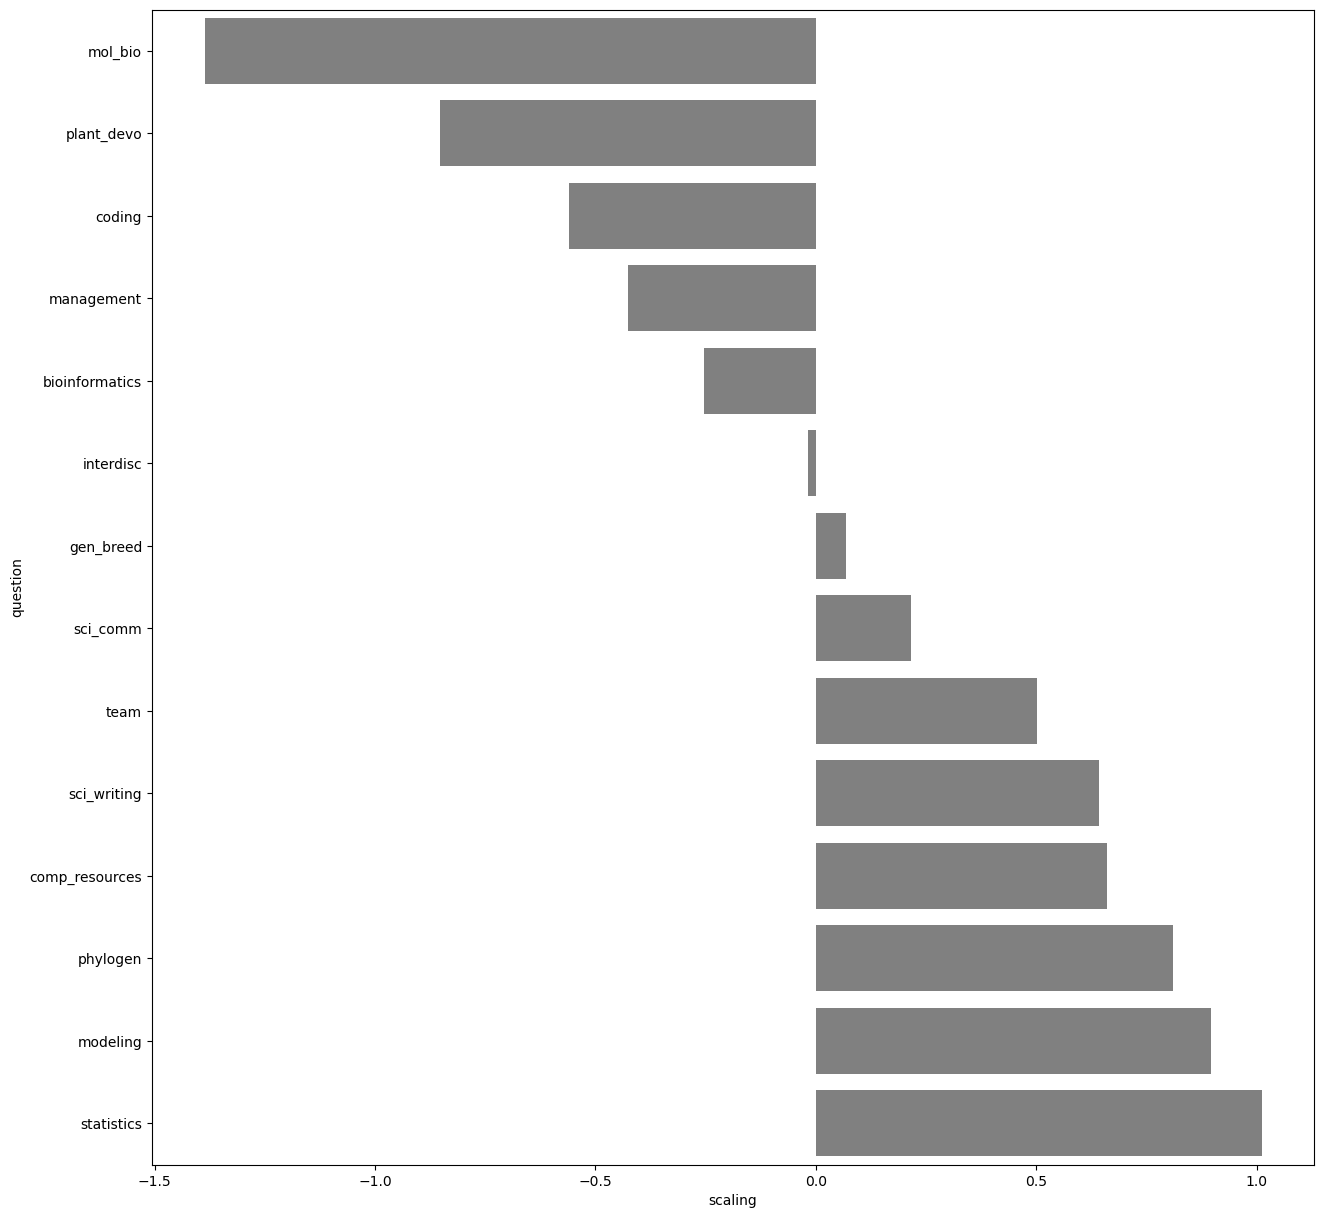

In [5]:
# PLOT SCALINGS

# store scalings in a list
scalings = [] 

for i in range(len(lda.scalings_)):
    scalings.append(lda.scalings_[i][0])
    
# create list of original questions from 2020
questions = ['coding', 'statistics', 'modeling', 'bioinformatics', 'comp_resources',
       'mol_bio', 'gen_breed', 'plant_devo', 'phylogen', 'team', 'management',
       'interdisc', 'sci_comm', 'sci_writing']

# create a df of scalings
df.scalings = pd.DataFrame(list(zip(questions, scalings)),
               columns =['question', 'scaling'])
df.scalings = df.scalings.sort_values(['scaling']).reset_index(drop=True) 

# plot scaling values
plt.figure(figsize=(15,15))
sns.barplot(data=df.scalings, y="question", x="scaling", color="grey")

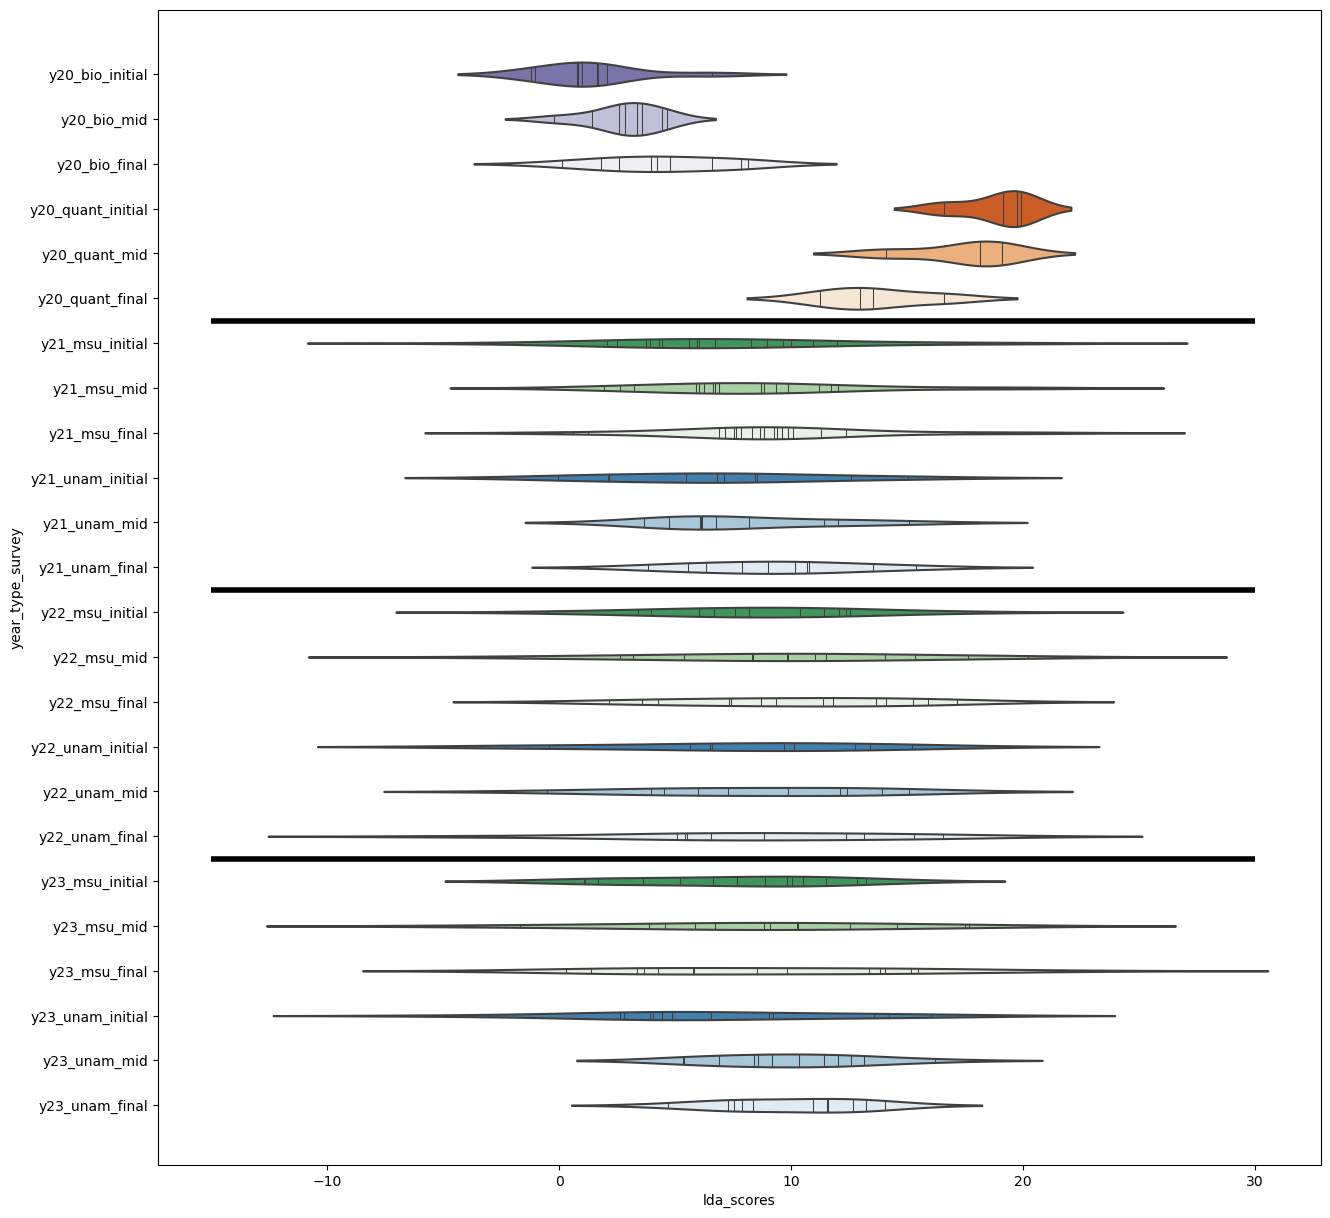

In [6]:
# PLOT LDA SCORES

all_years["lda_scores"] = lda_scores

order = ["y20_bio_initial","y20_bio_mid","y20_bio_final",
        "y20_quant_initial","y20_quant_mid","y20_quant_final",
        "y21_msu_initial","y21_msu_mid","y21_msu_final",
        "y21_unam_initial","y21_unam_mid","y21_unam_final",
        "y22_msu_initial","y22_msu_mid","y22_msu_final",
        "y22_unam_initial","y22_unam_mid","y22_unam_final",
        "y23_msu_initial","y23_msu_mid","y23_msu_final",
        "y23_unam_initial","y23_unam_mid","y23_unam_final"]

colors = ["#756bb1","#bcbddc","#efedf5", # bio initial, mid, final colors
          "#e6550d","#fdae6b","#fee6ce", # quant initial, mid, final colors
    
        "#31a354","#a1d99b","#e5f5e0", # msu initial, mid, final colors
          "#3182bd","#9ecae1","#deebf7", # unam initial, mid, final colors
         "#31a354","#a1d99b","#e5f5e0", # msu initial, mid, final colors
          "#3182bd","#9ecae1","#deebf7", # unam initial, mid, final colors
          "#31a354","#a1d99b","#e5f5e0", # msu initial, mid, final colors
          "#3182bd","#9ecae1","#deebf7" # unam initial, mid, final colors
         ] 

plt.figure(figsize=(15,15))
sns.violinplot(data=all_years, x="lda_scores", y="year_type_survey",
               order=order,inner="stick", bw=0.7, palette=colors)
# plt.hlines(y=[2.5,8.5,14.5], xmin=-15, xmax=30, linestyles="dashed", color="k")
plt.hlines(y=[5.5,11.5,17.5], xmin=-15, xmax=30, linestyles="solid", lw=4, color="k")

In [7]:
# EVALUATE MODEL

# define method to evaluate model
# 10 splits/folds, 3 times repeated
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model (using LDA model for only 2020 data, bio vs. comp)
scores = cross_val_score(lda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   

0.9361111111111111


In [8]:
# SPECIFIC COMPARISONS USING KRUSKAL-WALLIS TEST

# y20, BIO vs QUANT
bio = all_years["lda_scores"][all_years["type"]=="bio"]
quant = all_years["lda_scores"][all_years["type"]=="quant"]
print("y20 bio vs quant: pval =", stats.kruskal(bio, quant)[1])

# y20, BIO initial/mid/final
year20 = all_years[all_years["year"]=="y20"]
bio_initial = year20["lda_scores"][year20["type_survey"]=="bio_initial"]
bio_mid = year20["lda_scores"][year20["type_survey"]=="bio_mid"]
bio_final = year20["lda_scores"][year20["type_survey"]=="bio_final"]
print("change within bio y20: pval =", stats.kruskal(bio_initial, bio_mid, bio_final)[1])

# y20, QUANT initial/mid/final
quant_initial = year20["lda_scores"][year20["type_survey"]=="quant_initial"]
quant_mid = year20["lda_scores"][year20["type_survey"]=="quant_mid"]
quant_final = year20["lda_scores"][year20["type_survey"]=="quant_final"]
print("change within quant y20: pval =", stats.kruskal(quant_initial, quant_mid, quant_final)[1])

# y21, MSU vs UNAM
year21 = all_years[all_years["year"]=="y21"]
msu21 = year21["lda_scores"][year21["type"]=="msu"]
unam21 = year21["lda_scores"][year21["type"]=="unam"]
print("y21 msu vs unam: pval =", stats.kruskal(msu21, unam21)[1])   

# y21, MSU initial/mid/final
msu_initial21 = year21["lda_scores"][year21["type_survey"]=="msu_initial"]
msu_mid21 = year21["lda_scores"][year21["type_survey"]=="msu_mid"]
msu_final21 = year21["lda_scores"][year21["type_survey"]=="msu_final"]
print("change within msu y21: pval =", stats.kruskal(msu_initial21, msu_mid21, msu_final21)[1])

# y21, UNAM initial/mid/final
unam_initial21 = year21["lda_scores"][year21["type_survey"]=="unam_initial"]
unam_mid21 = year21["lda_scores"][year21["type_survey"]=="unam_mid"]
unam_final21 = year21["lda_scores"][year21["type_survey"]=="unam_final"]
print("change within unam y21: pval =", stats.kruskal(unam_initial21, unam_mid21, unam_final21)[1])

# y22, MSU vs UNAM
year22 = all_years[all_years["year"]=="y22"]
msu22 = year22["lda_scores"][year22["type"]=="msu"]
unam22 = year22["lda_scores"][year22["type"]=="unam"]
print("y22 msu vs unam: pval =", stats.kruskal(msu22, unam22)[1]) 

# y22, MSU initial/mid/final
msu_initial22 = year22["lda_scores"][year22["type_survey"]=="msu_initial"]
msu_mid22 = year22["lda_scores"][year22["type_survey"]=="msu_mid"]
msu_final22 = year22["lda_scores"][year22["type_survey"]=="msu_final"]
print("change within msu y22: pval =", stats.kruskal(msu_initial22, msu_mid22, msu_final22)[1])

# y22, UNAM initial/mid/final
unam_initial22 = year22["lda_scores"][year22["type_survey"]=="unam_initial"]
unam_mid22 = year22["lda_scores"][year22["type_survey"]=="unam_mid"]
unam_final22 = year22["lda_scores"][year22["type_survey"]=="unam_final"]
print("change within unam y22: pval =", stats.kruskal(unam_initial22, unam_mid22, unam_final22)[1])

# y23, MSU vs UNAM
year23 = all_years[all_years["year"]=="y23"]
msu23 = year23["lda_scores"][year23["type"]=="msu"]
unam23 = year23["lda_scores"][year23["type"]=="unam"]
print("y23 msu vs unam: pval =", stats.kruskal(msu23, unam23)[1])  

# y23, MSU initial/mid/final
msu_initial23 = year23["lda_scores"][year23["type_survey"]=="msu_initial"]
msu_mid23 = year23["lda_scores"][year23["type_survey"]=="msu_mid"]
msu_final23 = year23["lda_scores"][year23["type_survey"]=="msu_final"]
print("change within msu y23: pval =", stats.kruskal(msu_initial23, msu_mid23, msu_final23)[1])

# y23, UNAM initial/mid/final
unam_initial23 = year23["lda_scores"][year23["type_survey"]=="unam_initial"]
unam_mid23 = year23["lda_scores"][year23["type_survey"]=="unam_mid"]
unam_final23 = year23["lda_scores"][year23["type_survey"]=="unam_final"]
print("change within unam y23: pval =", stats.kruskal(unam_initial23, unam_mid23, unam_final23)[1])


y20 bio vs quant: pval = 8.243906238216795e-07
change within bio y20: pval = 0.022002955730866393
change within quant y20: pval = 0.036600539154270834
y21 msu vs unam: pval = 0.809469960236276
change within msu y21: pval = 0.2929318018779115
change within unam y21: pval = 0.41211550668097907
y22 msu vs unam: pval = 0.464772452300797
change within msu y22: pval = 0.721764764732546
change within unam y22: pval = 0.9910084102440324
y23 msu vs unam: pval = 0.5882279645944724
change within msu y23: pval = 0.7814042638576914
change within unam y23: pval = 0.14659958871124096


# MSU vs UNAM

In [9]:
# READ IN DATA

df = pd.read_csv("./dataset.csv")

# mask for years 2021, 2022, 2023
df21 = df[df["year"]=="y21"]
df22 = df[df["year"]=="y22"]
df23 = df[df["year"]=="y23"]

# concatenate and get column names
just_unam = pd.concat([df21, df22, df23], ignore_index=True, axis=0)
just_unam.columns

Index(['year', 'survey', 'type', 'type_survey', 'year_type_survey', 'coding',
       'statistics', 'modeling', 'command_line', 'bioinformatics',
       'comp_resources', 'mol_bio', 'gen_breed', 'plant_devo', 'phylogen',
       'team', 'other_countries', 'across_languages', 'management',
       'interdisc', 'sci_comm', 'sci_writing'],
      dtype='object')

In [10]:
# CREATE LDA MODEL

# define predictor (X) and response (y) variables
X = just_unam[['coding', 'statistics', 'modeling', 'command_line', 'bioinformatics',
       'comp_resources', 'mol_bio', 'gen_breed', 'plant_devo', 'phylogen',
       'team', 'other_countries', 'across_languages', 'management',
       'interdisc', 'sci_comm', 'sci_writing']]
y = just_unam['type']

# scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

# fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# get lda scores 
lda_scores = lda.transform(X) 

In [11]:
# GET SCALINGS

print(lda.scalings_)
print(lda.transform(np.identity(17)))

[[-0.56200335]
 [-0.02579343]
 [ 0.21481553]
 [ 0.41375859]
 [ 0.48579693]
 [-0.07635006]
 [ 0.95106668]
 [-0.78652891]
 [ 0.00778914]
 [-0.03764344]
 [-0.13085049]
 [-0.11524224]
 [ 0.57091794]
 [-0.27080909]
 [ 0.00492776]
 [-0.11438688]
 [ 0.30426434]]
[[-0.56200335]
 [-0.02579343]
 [ 0.21481553]
 [ 0.41375859]
 [ 0.48579693]
 [-0.07635006]
 [ 0.95106668]
 [-0.78652891]
 [ 0.00778914]
 [-0.03764344]
 [-0.13085049]
 [-0.11524224]
 [ 0.57091794]
 [-0.27080909]
 [ 0.00492776]
 [-0.11438688]
 [ 0.30426434]]


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_77922/1167169596.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.scalings = pd.DataFrame(list(zip(questions, scalings)),


<Axes: xlabel='scaling', ylabel='question'>

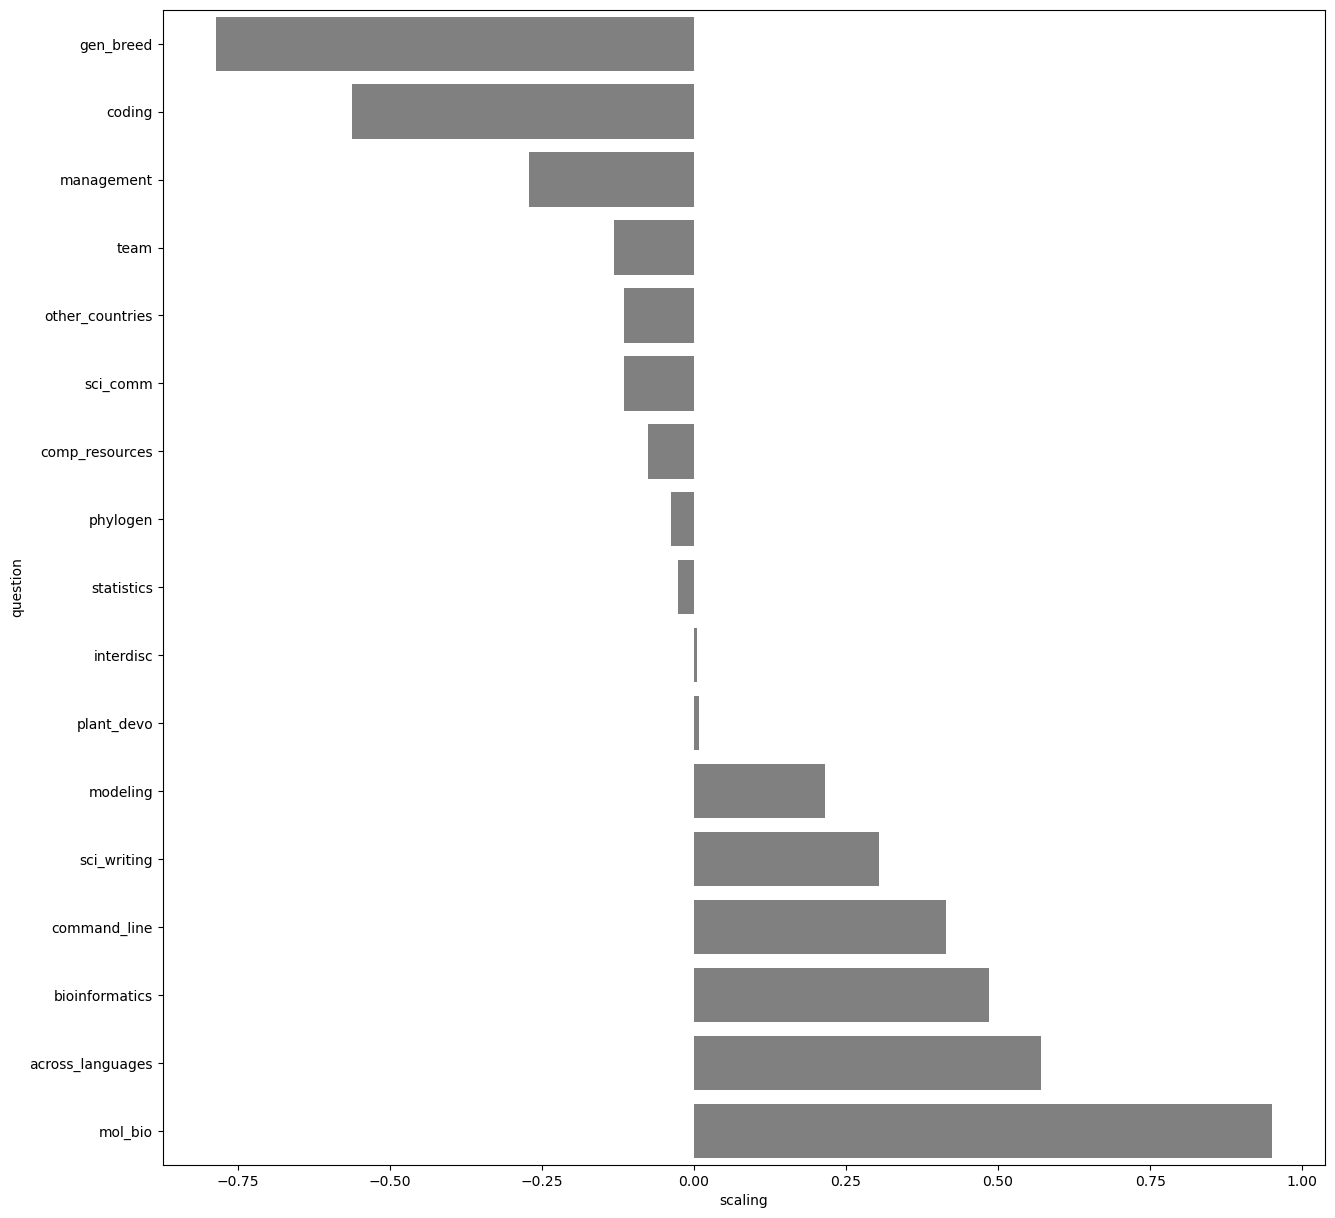

In [12]:
# PLOT SCALINGS

scalings = [] 

for i in range(len(lda.scalings_)):
    
    scalings.append(lda.scalings_[i][0])
    
# create list of original questions
questions = ['coding', 'statistics', 'modeling', 'command_line', 'bioinformatics',
   'comp_resources', 'mol_bio', 'gen_breed', 'plant_devo', 'phylogen',
   'team', 'other_countries', 'across_languages', 'management',
   'interdisc', 'sci_comm', 'sci_writing']

df.scalings = pd.DataFrame(list(zip(questions, scalings)),
               columns =['question', 'scaling'])


df.scalings = df.scalings.sort_values(['scaling']).reset_index(drop=True) 

plt.figure(figsize=(15,15))
sns.barplot(data=df.scalings, y="question", x="scaling", color="grey")

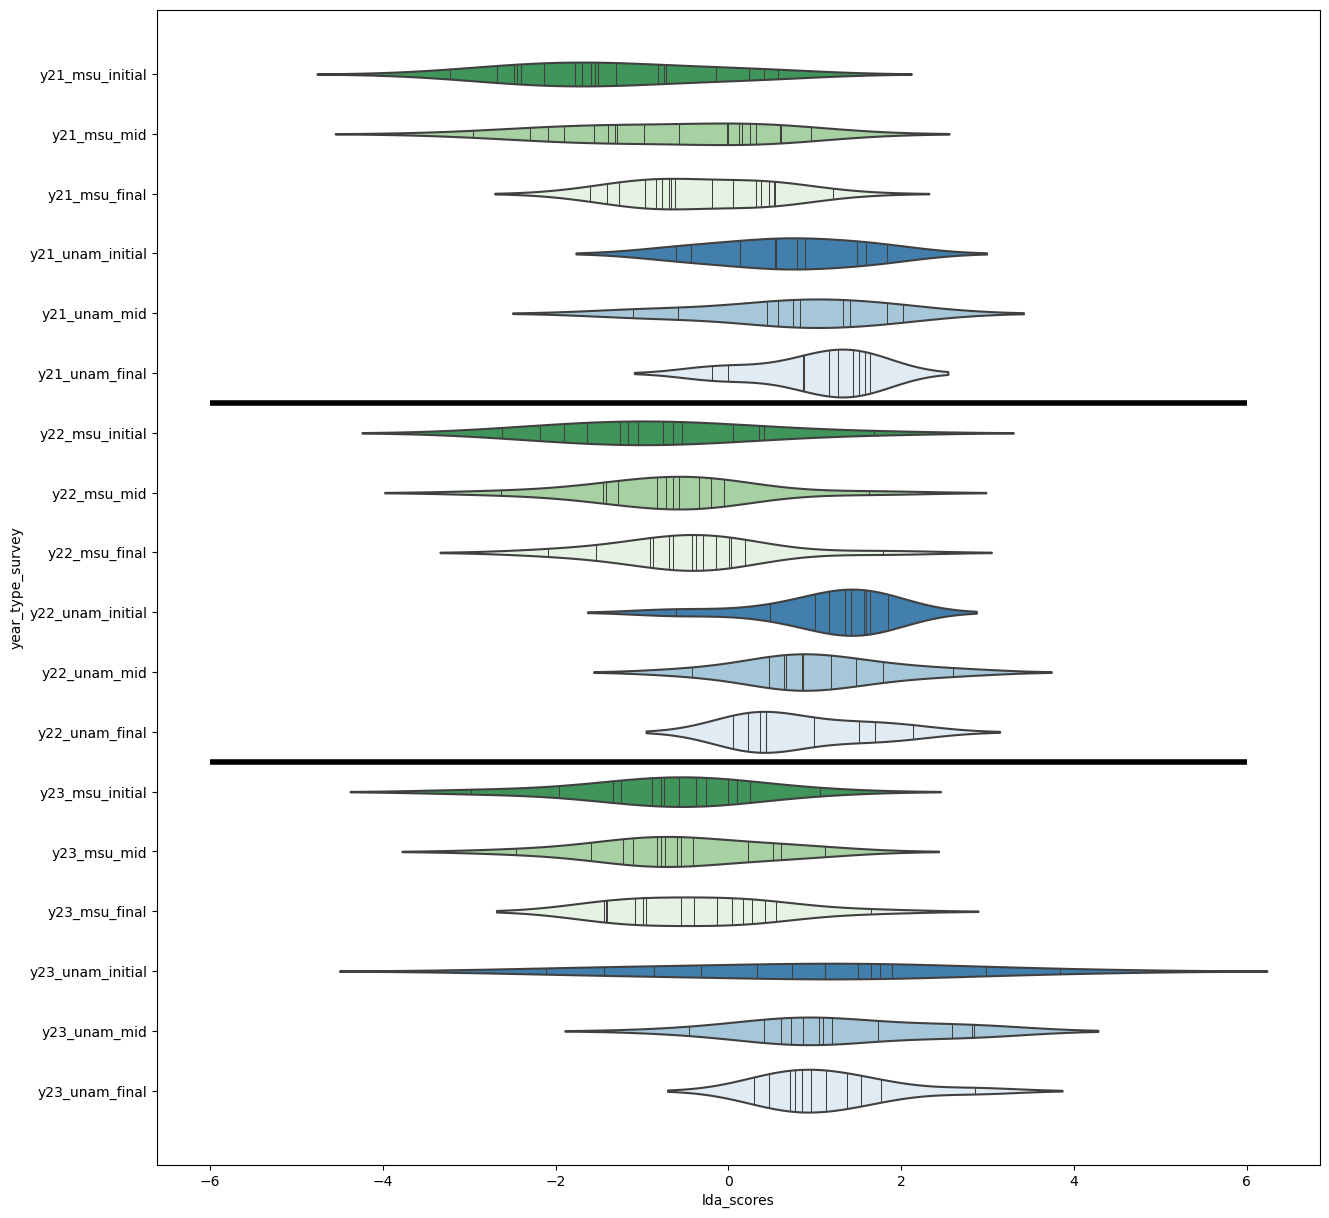

In [13]:
# PLOT LDA SCORES

just_unam["lda_scores"] = lda_scores

order = ["y21_msu_initial","y21_msu_mid","y21_msu_final",
        "y21_unam_initial","y21_unam_mid","y21_unam_final",
        "y22_msu_initial","y22_msu_mid","y22_msu_final",
        "y22_unam_initial","y22_unam_mid","y22_unam_final",
        "y23_msu_initial","y23_msu_mid","y23_msu_final",
        "y23_unam_initial","y23_unam_mid","y23_unam_final"
        ]

colors = ["#31a354","#a1d99b","#e5f5e0", # msu initial, mid, final colors
          "#3182bd","#9ecae1","#deebf7", # unam initial, mid, final colors
         "#31a354","#a1d99b","#e5f5e0", # msu initial, mid, final colors
          "#3182bd","#9ecae1","#deebf7", # unam initial, mid, final colors
        "#31a354","#a1d99b","#e5f5e0", # msu initial, mid, final colors
          "#3182bd","#9ecae1","#deebf7" # unam initial, mid, final colors
         ] 


plt.figure(figsize=(15,15))
sns.violinplot(data=just_unam, x="lda_scores", y="year_type_survey",
               order=order,inner="stick", bw=0.7, palette=colors)
#plt.hlines(y=[2.5,7.5], xmin=-6, xmax=6, linestyles="dashed")
plt.hlines(y=[5.5,11.5], xmin=-6, xmax=6, linestyles="solid", lw=4, color="black")


In [14]:
# EVALUATE MODEL

# define method to evaluate model
# 10 splits/folds, 3 times repeated
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(lda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   

0.7802536231884059


In [15]:
# SPECIFIC COMPARISONS USING KRUSKAL-WALLIS TEST

# y21, MSU vs UNAM
year21 = just_unam[just_unam["year"]=="y21"]
msu21 = year21["lda_scores"][year21["type"]=="msu"]
unam21 = year21["lda_scores"][year21["type"]=="unam"]
print("y21 msu vs unam: pval =", stats.kruskal(msu21, unam21)[1])   

# y21, MSU initial/mid/final
msu_initial21 = year21["lda_scores"][year21["type_survey"]=="msu_initial"]
msu_mid21 = year21["lda_scores"][year21["type_survey"]=="msu_mid"]
msu_final21 = year21["lda_scores"][year21["type_survey"]=="msu_final"]
print("change within msu y21: pval =", stats.kruskal(msu_initial21, msu_mid21, msu_final21)[1])

# y21, UNAM initial/mid/final
unam_initial21 = year21["lda_scores"][year21["type_survey"]=="unam_initial"]
unam_mid21 = year21["lda_scores"][year21["type_survey"]=="unam_mid"]
unam_final21 = year21["lda_scores"][year21["type_survey"]=="unam_final"]
print("change within unam y21: pval =", stats.kruskal(unam_initial21, unam_mid21, unam_final21)[1])

# y22, MSU vs UNAM
year22 = just_unam[just_unam["year"]=="y22"]
msu22 = year22["lda_scores"][year22["type"]=="msu"]
unam22 = year22["lda_scores"][year22["type"]=="unam"]
print("y22 msu vs unam: pval =", stats.kruskal(msu22, unam22)[1]) 

# y22, MSU initial/mid/final
msu_initial22 = year22["lda_scores"][year22["type_survey"]=="msu_initial"]
msu_mid22 = year22["lda_scores"][year22["type_survey"]=="msu_mid"]
msu_final22 = year22["lda_scores"][year22["type_survey"]=="msu_final"]
print("change within msu y22: pval =", stats.kruskal(msu_initial22, msu_mid22, msu_final22)[1])

# y22, UNAM initial/mid/final
unam_initial22 = year22["lda_scores"][year22["type_survey"]=="unam_initial"]
unam_mid22 = year22["lda_scores"][year22["type_survey"]=="unam_mid"]
unam_final22 = year22["lda_scores"][year22["type_survey"]=="unam_final"]
print("change within unam y22: pval =", stats.kruskal(unam_initial22, unam_mid22, unam_final22)[1])

# y23, MSU vs UNAM
year23 = just_unam[just_unam["year"]=="y23"]
msu23 = year23["lda_scores"][year23["type"]=="msu"]
unam23 = year23["lda_scores"][year23["type"]=="unam"]
print("y23 msu vs unam: pval =", stats.kruskal(msu23, unam23)[1])  

# y23, MSU initial/mid/final
msu_initial23 = year23["lda_scores"][year23["type_survey"]=="msu_initial"]
msu_mid23 = year23["lda_scores"][year23["type_survey"]=="msu_mid"]
msu_final23 = year23["lda_scores"][year23["type_survey"]=="msu_final"]
print("change within msu y23: pval =", stats.kruskal(msu_initial23, msu_mid23, msu_final23)[1])

# y23, UNAM initial/mid/final
unam_initial23 = year23["lda_scores"][year23["type_survey"]=="unam_initial"]
unam_mid23 = year23["lda_scores"][year23["type_survey"]=="unam_mid"]
unam_final23 = year23["lda_scores"][year23["type_survey"]=="unam_final"]
print("change within unam y23: pval =", stats.kruskal(unam_initial23, unam_mid23, unam_final23)[1])



y21 msu vs unam: pval = 3.5754184544793774e-09
change within msu y21: pval = 0.01164631675769025
change within unam y21: pval = 0.6132195453992159
y22 msu vs unam: pval = 3.774689069578284e-09
change within msu y22: pval = 0.5449701780279288
change within unam y22: pval = 0.33654202199537603
y23 msu vs unam: pval = 2.385891222852908e-08
change within msu y23: pval = 0.805729461469636
change within unam y23: pval = 0.9269630482682536
